<a href="https://colab.research.google.com/github/AyaSerageldin/Medical-Symptoms-Analysis/blob/master/CNN_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras import Sequential
from keras.src.applications.vgg16 import VGG16
from keras.src.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_path= '/content/drive/MyDrive/xray_images/chest_xray/train'
test_path = '/content/drive/MyDrive/xray_images/chest_xray/test'
val_path = '/content/drive/MyDrive/xray_images/chest_xray/val'

In [5]:
img_height, img_width = 224, 224
batch_size = 32

# Create an instance of the ImageDataGenerator with augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#  train_path,
#   image_size=(img_height, img_width),
#   batch_size=batch_size
# )

train_dataset = train_datagen.flow_from_directory(
    train_path,
   target_size=(224, 224),
   batch_size=batch_size,
     class_mode='binary'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                   image_size=(img_height, img_width),
                                                                   batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_path,
                                                                   image_size=(img_height, img_width),
                                                                   batch_size=batch_size)

Found 5199 images belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [6]:
#VERIFYING DATASETS WERE LOADED CORRECTLY#
#class_names = train_dataset.class_names

class_names = train_dataset.class_indices
print(class_names)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [7]:
#for images, labels in train_dataset.take(1):  # Take the first batch of images and labels

    # 'images' will contain a batch of images
    # 'labels' will contain the corresponding labels for those images

images, labels = next(train_dataset)
print(images.shape)  # Prints the shape of the images tensor
print(labels.shape)  # Prints the shape of the labels tensor

(32, 224, 224, 3)
(32,)


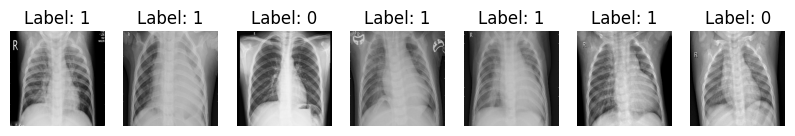

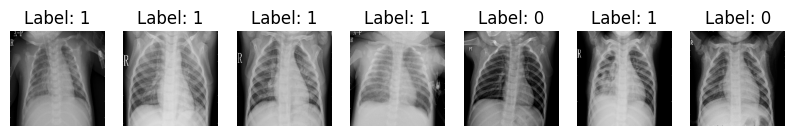

In [15]:
import matplotlib.pyplot as plt
def display_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")

    plt.show()


display_images(test_dataset,7)
display_images(val_dataset,7)

In [ ]:
def img_normalisation(image, label):
    image = tf.cast(image, tf.float32) / 255
    return image, label


#train_dataset = train_dataset.map(img_normalisation)
test_dataset = test_dataset.map(img_normalisation)
val_dataset = val_dataset.map(img_normalisation)

# for images, labels in train_dataset.take(1):
#     print(images.shape)  # Should print (batch_size, 224, 224, 1)
#     print(images.numpy().min(), images.numpy().max())  # Should print values in the range [0, 1]

images, labels = next(train_dataset)
print(images.shape)  # Prints the shape of the images tensor
print(labels.shape)  # Prints the shape of the labels tensor


(32, 224, 224, 3)
(32,)


In [ ]:
#VGG_MODEL#
model = Sequential()
#model.add(VGG16(include_top = False, weights = weights, input_shape = (224,224,3)))
model.add(VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# for image_batch, label_batch in train_dataset.take(1):
#     print(image_batch.shape)

images, labels = next(train_dataset)
print(images.shape)

(32, 224, 224, 3)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(Callback):
    def __init__(self, val_data):
        super(MetricsCallback, self).__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        val_pred = []
        val_true = []

        # Go through validation dataset
        for x_val, y_val in self.val_data:
            y_pred = self.model.predict(x_val)
            y_pred = (y_pred > 0.5).astype(int)

            val_pred.extend(y_pred)
            val_true.extend(y_val)

        val_pred = np.array(val_pred).flatten()
        val_true = np.array(val_true).flatten()

        precision = precision_score(val_true, val_pred, average='binary')
        recall = recall_score(val_true, val_pred, average='binary')
        f1 = f1_score(val_true, val_pred, average='binary')

        print(f'Epoch {epoch + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
metrics_callback = MetricsCallback(val_dataset)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)



callbacks = [early_stopping, metrics_callback,reduce_lr]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks  # Specify callbacks as a keyword argument
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
Epoch 1 - Precision: 0.8571, Recall: 0.7500, F1-score: 0.8000
163/163 ━━━━━━━━━━━━━━━━━━━━ 741s 4s/step - accuracy: 0.7126 - loss: 10.5919 - val_accuracy: 0.8125 - val_loss: 9.9674 - learning_rate: 0.0100
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 2 - Precision: 0.8750, Recall: 0.8750, F1-score: 0.8750
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 960ms/step - accuracy: 0.8472 - loss: 9.5900 - val_accuracy: 0.8750 - val_loss: 9.1296 - learning_rate: 0.0100
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 3 - Precision: 0.8889, Recall: 1.0000, F1-score: 0.9412
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9350 - loss: 8.8485 - val_accuracy: 0.9375 - val_loss: 8.4688 - learning_rate: 0.0100
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 4 - Precision: 0.8000, Recall: 1.0000, F1-score: 0.8889
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 937ms/step - accuracy: 0.9436 - loss: 8.2758 - val_accuracy: 0.8750 - val_loss: 7.9788 - learning_rate

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

# Get the true labels and predicted labels for the test dataset
y_true = []
y_pred = []

for x_test, y_test in test_dataset:
    # Predict the labels for the test data
    y_pred_batch = model.predict(x_test)

    # If you're using sigmoid for binary classification, apply a threshold
    y_pred_batch = (y_pred_batch > 0.5).astype(int)

    # Flatten and extend the lists
    y_true.extend(y_test.numpy().flatten())  # Convert true labels to numpy
    y_pred.extend(y_pred_batch.flatten())    # Convert predictions to numpy

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.9243 - loss: 5.5052
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Precision: 0.9125
Recall: 0.9897
F1-Score: 0.9496
Test Accuracy: 0.93
